In [5]:
import numpy as np
from typing import List, Callable, Optional, Tuple, override
import copy
import matplotlib.pyplot as plt
import sympy as sym

In [6]:
# allow for multiple dimensions through use of numpy array
def euler(x: np.array, h: float, f: Callable[[np.array], np.array]) -> np.array:
    
    return x + h * f(x)

def heun(x: np.array, h: float, f: Callable[[np.array], np.array]) -> np.array:
    eulerStep = euler(x, h, f)

    return x + 0.5 * h * f(x) + 0.5 * h * f(eulerStep)

def rk4(x: np.array, h: float, f: Callable[[np.array], np.array]) -> np.array:
    k0 = f(x + h * 0.0)
    k1 = f(x + h * (0.5 * k0))
    k2 = f(x + h * (0.5 * k1))
    k3 = f(x + h * (1.0 * k2))

    return x + 0.5 * h * ((1.0/6.0) * k0 + (2.0 / 6.0) * k1 + (2.0 / 6.0) * k2 + (1.0 / 6.0) * k3)

In [7]:
def runSimulation(
    x0: np.array, 
    h: float, 
    nSteps: int, 
    f: Callable[[np.array], np.array], 
    method: Callable[[np.array, float, Callable[[np.array], np.array]], np.array]
) -> List[Tuple[float, float]]:
    if nSteps < 1:
        raise "Error in nSteps"
    allOutputs = [(0.0, x0)]
    while len(allOutputs) <= nSteps:
        (t, x) = allOutputs[-1]
        allOutputs.append((
            t + h, 
            method(x, h, f)
        ))
    return allOutputs

In [419]:
a = 1.
b = -0.1
eps = 0.5
I = 1

f = lambda arr2d: np.array([arr2d[0] - arr2d[0]**3 - arr2d[1] + I, eps * (arr2d[0] - a * arr2d[1] - b)])

In [420]:
newtonFuncToSolve = lambda u: -u**3 + (1 - (1 / a)) * u + (b / a) + I
newtonDeriv = lambda u: -3 * u**2 + (1 - (1 / a))

newtonGuess = -0.1
while abs(newtonFuncToSolve(newtonGuess)) > 1e-12:
    newtonGuess = newtonGuess - newtonFuncToSolve(newtonGuess) / newtonDeriv(newtonGuess)
ueq = newtonGuess
veq = (newtonGuess - b) / a

In [421]:
ueq

0.9654893846056298

In [422]:
veq

1.06548938460563

In [424]:
f([ueq, veq])

array([-4.44089210e-16, -4.16333634e-17])

In [425]:
jacobianAtEq = np.array([[-3*(ueq**2) + 1, -1], [eps, - a * eps]])
np.linalg.eig(jacobianAtEq)

EigResult(eigenvalues=array([-1.14825463+0.28242864j, -1.14825463-0.28242864j]), eigenvectors=array([[ 0.81649658+0.j        ,  0.81649658-0.j        ],
       [-0.52929769-0.23060202j, -0.52929769+0.23060202j]]))

In [403]:
h = 0.1
nSteps = 7500
x0 = np.array([ueq, veq + 1.])#np.array([-2 * b, 0])
# x0 = np.array([-3, 3])

simRun = runSimulation(x0 = x0, h = h, nSteps = nSteps, f = f, method = rk4)

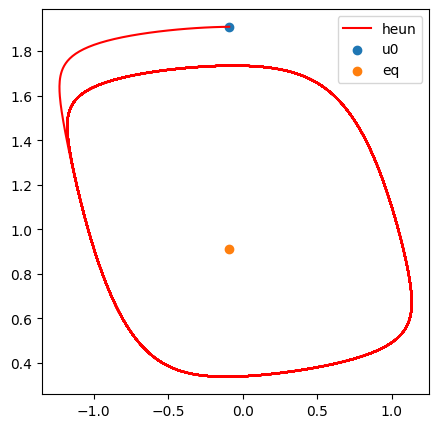

In [404]:
plt.figure(figsize = (5, 5))
plt.plot([t[1][0] for t in simRun], [t[1][1] for t in simRun], label = 'heun', color = 'r')
plt.scatter([x0[0]], [x0[1]], label = 'u0')
plt.scatter([ueq], [veq], label = 'eq')
plt.legend(loc='upper right')

plt.show()

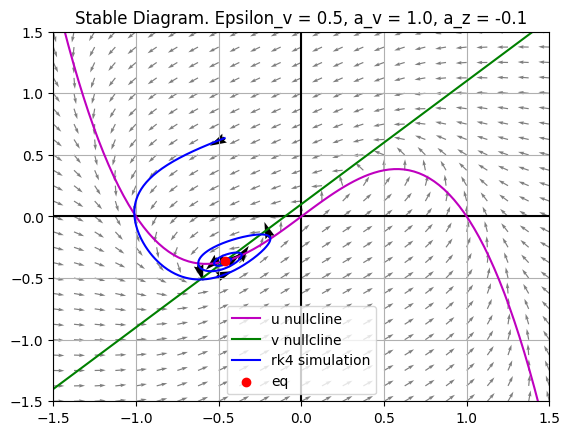

In [388]:
# Meshgrid 
plt.figure()

plt.axhline(y = 0, color = 'k')
plt.axvline(x = 0, color = 'k')

m = 1.5

x, y = np.meshgrid(np.linspace(-m, m, 25),  
                   np.linspace(-m, m, 25)) 
  
# Directional vectors 
u = np.array([[f(np.array([x[i, j], y[i, j]]))[0] for j in range(x.shape[1])] for i in range(x.shape[0])])
v = np.array([[f(np.array([x[i, j], y[i, j]]))[1] for j in range(x.shape[1])] for i in range(x.shape[0])])

unorm = u / (np.sqrt(u*u + v*v))
vnorm = v / (np.sqrt(u*u + v*v))
  
# Plotting Vector Field with QUIVER 
plt.quiver(x, y, unorm, vnorm, color='k', alpha = 0.5)

xGen = np.linspace(-m, m, 100)
plt.plot(xGen, -xGen**3 + xGen, label = 'u nullcline', color = 'm')
plt.plot(xGen, (xGen - b) / a, label = 'v nullcline', color = 'g')

xSim = np.array([t[1][0] for t in simRun])
ySim = np.array([t[1][1] for t in simRun])
plt.plot([t[1][0] for t in simRun], [t[1][1] for t in simRun], label = 'rk4 simulation', color = 'b')

xsToPlot = xSim[:-1]
xQuivsToPlot = np.array(xSim[1:]-xSim[:-1])
ysToPlot = ySim[:-1]
yQuivsToPlot = np.array(ySim[1:]-ySim[:-1])

xQuivsToPlotNorm = xQuivsToPlot / np.sqrt(xQuivsToPlot*xQuivsToPlot + yQuivsToPlot*yQuivsToPlot)
yQuivsToPlotNorm = yQuivsToPlot / np.sqrt(xQuivsToPlot*xQuivsToPlot + yQuivsToPlot*yQuivsToPlot)
skip = 100
plt.quiver(xsToPlot[::skip], ysToPlot[::skip], xQuivsToPlotNorm[::skip], yQuivsToPlotNorm[::skip], scale=30, color='k')

plt.scatter([ueq], [veq], color = 'r', label = 'eq', zorder = 5)

plt.title(f'Stable Diagram. Epsilon_v = {eps}, a_v = {a}, a_z = {b}') 

# # Setting x, y boundary limits 
plt.xlim(-m, m) 
plt.ylim(-m, m) 

plt.legend()
  
# # Show plot with grid 
plt.grid() 
plt.show() 